# Problem Set 6: Particle Tracking
---
## Setup

In [3]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Imports
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['lines.markersize'] = 1
# OpenCV Videos
PLAY_VIDEO = True

---
## 1. Particle Filter Tracking

In [5]:
# Initial State
with open('pres_debate.txt', 'r') as f:
    x0, y0, w0, h0 = [int(float(n)) for n in f.readline().split()]

In [89]:
class ParticleFilter:
    # ref: https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
    def __init__(self, template, h, w, N=1000):
        '''
        Create random particles.
        '''
        self.template = template
        self.N = N
        self.ht, self.wt = template.shape
        self.h, self.w = h, w
        self.weights = np.full(N, 1/N)
        self.particles = np.zeros((N, 2))
        self.particles[:, 0] = np.random.uniform(0, w, N)
        self.particles[:, 1] = np.random.uniform(0, h, N)
        return
    
    def predict(self, sigma=10):
        '''
        Predict next state of set of particles.
        '''
        noise = np.random.normal(0, sigma, (self.N, 2))
        self.particles += noise
        self.particles[:,0] = np.clip(self.particles[:,0], 0, self.w - 1)
        self.particles[:,1] = np.clip(self.particles[:,1], 0, self.h - 1)
        return

    def update(self, frame, sigma_mse=0.04):
        '''
        Update weights of set of particles.
        '''
        weights = np.zeros(self.N)
        x, y = self.particles[:, 0], self.particles[:, 1]
        x1 = (x-self.wt//2).astype(int)
        x2 = x1 + self.wt
        y1 = (y-self.ht//2).astype(int)
        y2 = y1 + self.ht
        for ix in range(self.N):
            state = frame[y1[ix]:y2[ix], x1[ix]:x2[ix]]
            if np.all(state.shape == self.template.shape):
                mse = np.mean((self.template - state)**2)
                p = np.exp(-mse/(2*sigma_mse**2))
            else:
                p = 0.0
            weights[ix] = p
        weights /= np.sum(weights)
        self.weights = weights
        return

    def resample(self):
        '''
        Resample set based on weights.
        '''
        indices = np.random.choice(self.N, size=self.N, p=self.weights)
        self.particles = self.particles[indices]
        return

    def estimate_state(self):
        '''
        Get state estimate as weighted mean of particles
        '''
        return np.average(self.particles, weights=self.weights, axis=0)

    def plot_particles(self, ax, colour='r'):
        '''
        Get state estimate as weighted mean of particles
        '''
        ax.scatter(self.particles[:, 0], self.particles[:, 1], color=colour)
        return
    
    def plot_state_estimate(self, ax):
        '''
        Plot the bounding box based on state parameters.
        '''
        # Bounding box centres
        x, y = self.estimate_state()
        x -= self.wt//2
        y -= self.ht//2
        # Rectangle patch
        rect = patches.Rectangle((x, y), self.wt, self.ht, linewidth=2, edgecolor='lime', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        return

In [90]:
def get_frame(videofile, n):
    '''
    Get the nth frame from the video.
    '''
    cap = cv2.VideoCapture(videofile)
    for _ in range(n):
        ret, frame = cap.read()
        if ret == True:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float) / 255
        else:
            break
    cap.release()
    return gray

### 1.1 Base tracker

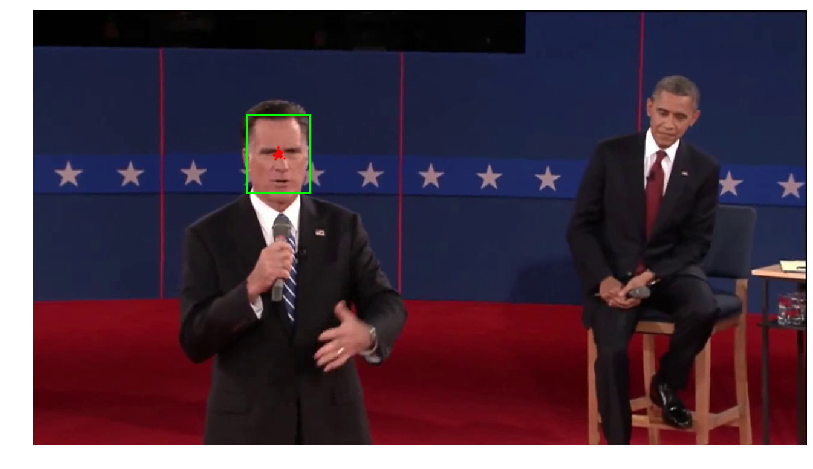

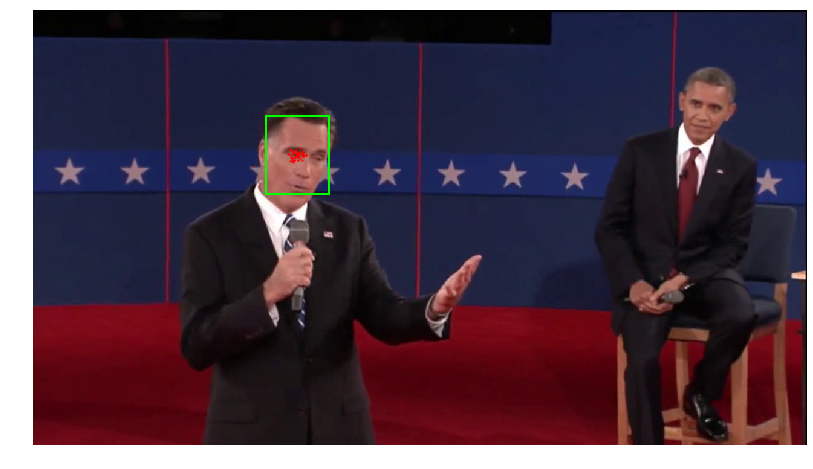

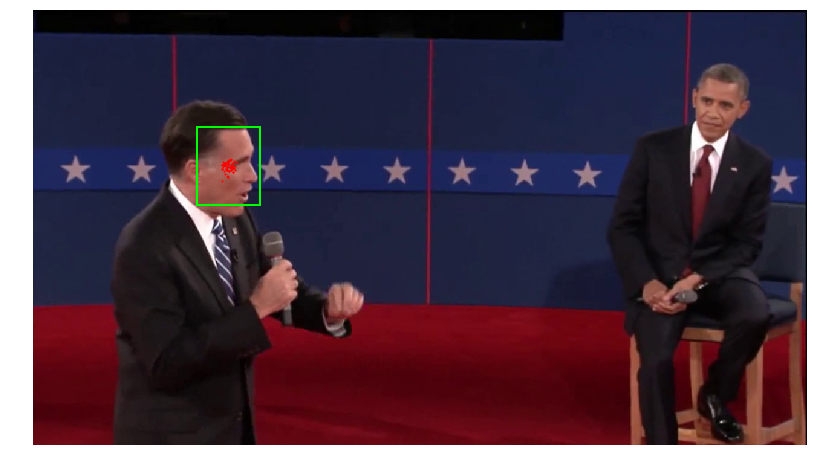

In [91]:
frames = [28, 84, 144]
videofile = 'pres_debate.avi'
firstframe = get_frame(videofile, 1)
template = firstframe[y0:y0+h0, x0:x0+w0]
h, w = firstframe.shape
face_tracker = ParticleFilter(template, h, w, N=100)
cap = cv2.VideoCapture(videofile)
ix = 1
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    framegr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float) / 255

    face_tracker.predict()
    face_tracker.update(framegr)
    face_tracker.resample()
    
    if ix in frames:
        fig, ax = plt.subplots(1, 1)
        ax.imshow(frame[:, :, ::-1])
        ax.axis('off')
        face_tracker.plot_particles(ax)
        face_tracker.plot_state_estimate(ax)
#     for p in face_tracker.particles:
#         cv2.circle(frame, tuple(p.astype(int)), 2, (0,0,255), -1)
#     cv2.imshow(videofile, frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
    ix += 1
cv2.destroyAllWindows()
cap.release()

### 1.2

### 1.3

### 1.4

### 1.5 Noisy Clip

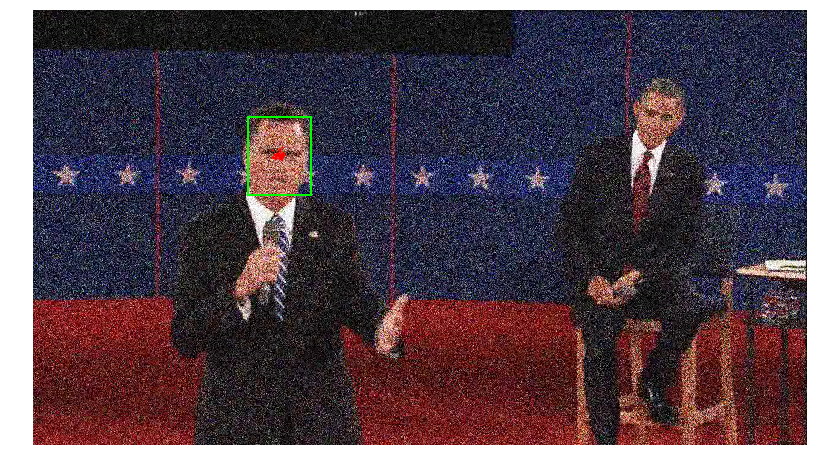

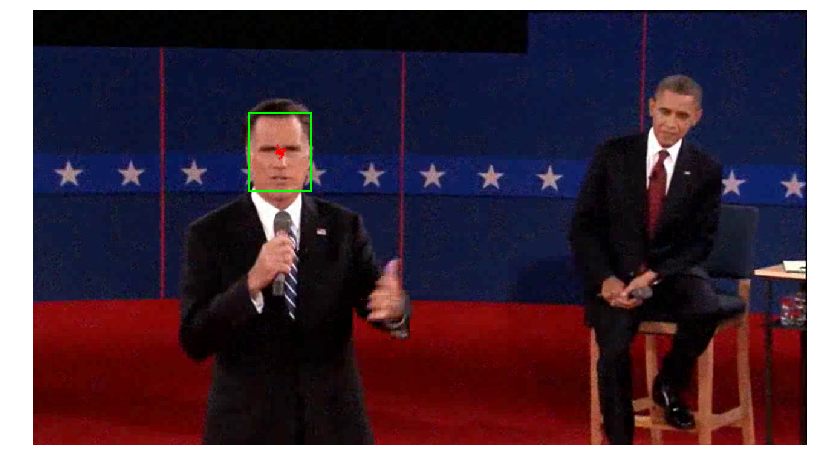

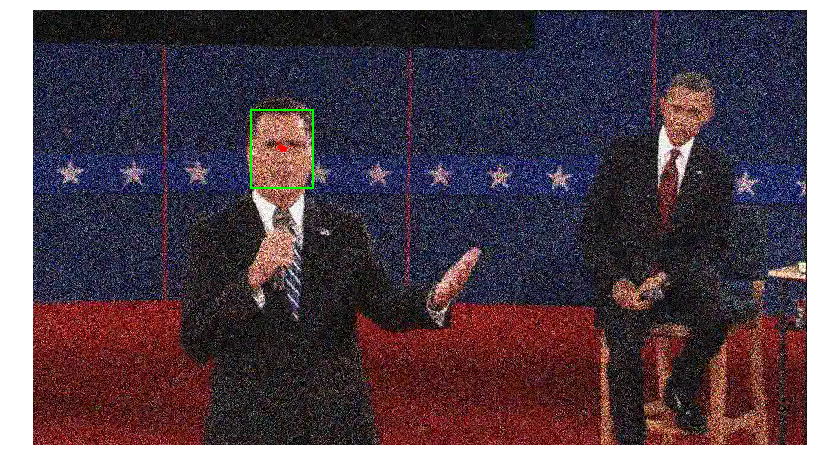

In [94]:
frames = [14, 32, 46]
videofile = 'noisy_debate.avi'
face_tracker = ParticleFilter(template, h, w, N=100)
cap = cv2.VideoCapture(videofile)
ix = 1
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    framegr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float) / 255

    face_tracker.predict()
    face_tracker.update(framegr)
    face_tracker.resample()
    
    if ix in frames:
        fig, ax = plt.subplots(1, 1)
        ax.imshow(frame[:, :, ::-1])
        ax.axis('off')
        face_tracker.plot_particles(ax)
        face_tracker.plot_state_estimate(ax)
    for p in face_tracker.particles:
        cv2.circle(frame, tuple(p.astype(int)), 2, (0,0,255), -1)
    cv2.imshow(videofile, frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    ix += 1
cv2.destroyAllWindows()
cap.release()

---
## 2. Appearance Model Update

### 2.1 Reduce

### 2.2 Noisy Clip

---
## 3. Incorporating More Dynamics

### 3.1 Noisy Clip

### 3.2 Noisy Clip